In [45]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import FreqDist
ps = PorterStemmer()
from nltk.corpus import stopwords
import numpy as np

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/will/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/will/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/will/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [46]:
answers="cheese	ice	sore	boat	watch	bill	chair	honey	soda	forest	band	snow	pin	day	gold	school	bank	blue	space	coat	common	girl	pot	soap	hole	game	match	bowl	copy	bow".split("\t")
questions="cottage / swiss / cake	cream / skate / water	loser / throat / spot	show / life / row	night / wrist / stop	duck / fold / dollar	rocking / wheel / high	dew / comb / bee	fountain / baking / pop	preserve / ranger / tropical	aid / rubber / wagon	flake / mobile / cone	safety / cushion / point	dream / break / light	fish / mine / rush	high / district / house	river / note / account	print / berry / bird	cadet / capsule / ship	fur / rack / tail	sense / courtesy / place	flower / friend / scout	pie / luck / belly	opera / hand / dish	fox / man / peep	piece / mind / dating	stick / maker / point	dust / cereal / fish	right / cat / carbon	cross / rain / tie".split('\t')
qq = []
usedwords = set()
for i in range(len(questions)):
    question_words = [s.strip() for s in questions[i].split("/")]
    answer = answers[i] 
    qq.append(question_words)
    usedwords|=set(question_words)|{answer}
    print(question_words,answer)
questions=qq
def checkvocab(vocab):
    return usedwords-vocab

print(len(answers),len(questions))

['cottage', 'swiss', 'cake'] cheese
['cream', 'skate', 'water'] ice
['loser', 'throat', 'spot'] sore
['show', 'life', 'row'] boat
['night', 'wrist', 'stop'] watch
['duck', 'fold', 'dollar'] bill
['rocking', 'wheel', 'high'] chair
['dew', 'comb', 'bee'] honey
['fountain', 'baking', 'pop'] soda
['preserve', 'ranger', 'tropical'] forest
['aid', 'rubber', 'wagon'] band
['flake', 'mobile', 'cone'] snow
['safety', 'cushion', 'point'] pin
['dream', 'break', 'light'] day
['fish', 'mine', 'rush'] gold
['high', 'district', 'house'] school
['river', 'note', 'account'] bank
['print', 'berry', 'bird'] blue
['cadet', 'capsule', 'ship'] space
['fur', 'rack', 'tail'] coat
['sense', 'courtesy', 'place'] common
['flower', 'friend', 'scout'] girl
['pie', 'luck', 'belly'] pot
['opera', 'hand', 'dish'] soap
['fox', 'man', 'peep'] hole
['piece', 'mind', 'dating'] game
['stick', 'maker', 'point'] match
['dust', 'cereal', 'fish'] bowl
['right', 'cat', 'carbon'] copy
['cross', 'rain', 'tie'] bow
30 30


In [47]:
dat_questions = [["rush","piece","night"],["mine","aid","cake"],["maker","cross","rubber"],["spot","dream","show"],["comb","wagon","skate"],["swiss","wrist","lucky"],["mobile","flower","fountain"],["fox","throat","dating"],["cadet","cat","river"],["cream","pie","cottage"]]

In [48]:
len([w for w in wn.words()])

147306

In [49]:
def preprocess(text):
    text = text.lower()
    #text = text.replace('-', '_')
    #text = ps.stem(text)
    
    if len(text)<3:
        return None
    
    if text in stop_words or any(char.isdigit() for char in text):
        return None
    synset = wn.synsets(wn.morphy(text),wn.NOUN)
    if not synset:
        return None
    freqs=0
    for s in synset:
        for l in s.lemmas():
            freqs+=l.count()
        
    return (text,freqs)

In [50]:
wordlist = {}

for w in wn.words():
    pw = preprocess(w)
    if pw!=None:
        text, freqs = pw
        wordlist[text] = freqs


In [51]:
print(len(wordlist)) #118672

118395


In [52]:
checkvocab(wordlist.keys())

{'rocking', 'tropical'}

In [53]:
#nounswords = {k:v for (k,v) in wordlist.items() if v>0 or '_' in k}

In [54]:
word2idx = {word[0]: i for i, word in enumerate(wordlist.items())}
idx2word = {i: word[0] for i, word in enumerate(wordlist.items())}
idx2freq = {i: word[1] for i, word in enumerate(wordlist.items())}

In [55]:
def getdefin(word):
    word = wn.morphy(word)
    definitions = set()
    #examples = set()
    synonyms = set()
    for e in wn.synsets(word,wn.NOUN):
        definitions |= set(e.definition().split(' '))

        #examples |= set(' '.join(e.examples()).split(' '))
        synonyms|=set(e.lemma_names())
    synonyms.discard(word)
    tw = 0
    
    relativeweights={}
    for d in definitions:
        idx = word2idx.get(d,-1)

        if idx!=-1:
            w = 1#np.log(1-1/(5+idx2freq[idx]))
            relativeweights[idx]=w
            tw+=w

    if len(synonyms)!=0: 
        frac_syn = 0.0
    else:
        frac_syn=0
        
    for k in relativeweights:
        relativeweights[k]*=(1-frac_syn)/tw
    
    
    ts = 0
    for s in synonyms:
        idx = word2idx.get(s,-1)
        if idx!=-1:
            ts+=1
    for s in synonyms:
        idx = word2idx.get(s,-1)
        if idx!=-1:
            relativeweights[idx]=relativeweights.get(idx,0)+frac_syn/ts
        
        
    return relativeweights

getdefin('ice_skating')

{56949: 0.5, 98936: 0.5}

In [56]:
superconnect = {}
for w in word2idx.keys():
    superconnect[word2idx[w]]=getdefin(w)
    


In [57]:
def getmatchstrength(querry,question,word):
    #querry = word+question
    if querry not in word2idx: return 0
    if question not in word2idx: return 0
    querryidx = word2idx[querry]
    questionidx = word2idx[question]
    return superconnect[querryidx].get(questionidx,0) #1
    

In [58]:
#['cream', 'skate', 'water'] ice
eps=5
totalwords=sum(idx2freq[w]+5 for w in idx2freq)
    


In [59]:
from wordfreq import word_frequency

In [60]:
import matplotlib.pyplot as plt

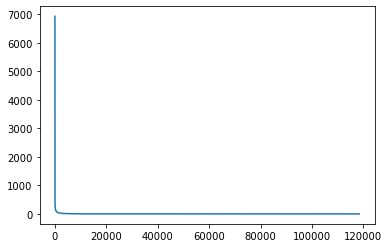

In [61]:
plt.plot(sorted(idx2freq.values(),reverse=True))


In [62]:
import csv
 
# csv file name
filename = "freq.csv"
 
# initializing the titles and rows list
fields = []
rows = []
 
totwords = 0
# reading csv file
with open(filename, 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile)
     
    # extracting field names through first row
    fields = next(csvreader)
 
    # extracting each data row one by one
    for row in csvreader:
        rows.append(row)
        totwords+=int(row[1])
 
word2freq={row[0]:int(row[1]) for row in rows}

In [63]:
1/totwords

2.011280872155747e-08

In [64]:
#log form 

def freq(w):
    idx=word2idx.get(w,-1)
    if idx==-1: return 1e-18
    
    return max(word2freq.get(w,0)/totwords,1/totwords)
    #return 1#((idx2freq.get(idx,0)+eps)/10**9)#/(10**9)

def combinations(w,qi):
    return [w+qi,qi+w,w+'_'+qi,qi+'_'+w,w+'-'+qi,qi+'-'+w]

def prodmaxcomb(word,question):
    prod=1
    for qi in question:
        prod+=np.log(max(freq(c) for c in combinations(word,qi)))
    return prod


def conditionalprob(word,question,totalcombs):
    #P_W_given_Q
    P_Wa=np.log(freq(word))
    P_Q=np.logaddexp.reduce([np.log(freq(question[0])),np.log(freq(question[1])),np.log(freq(question[2]))])
    
    P_Q_given_Wa = prodmaxcomb(word,question)-totalcombs
    
    return P_Q_given_Wa-P_Q+P_Wa

def getanswer(answer,question):
    
    totalcombs = np.logaddexp.reduce(np.array([prodmaxcomb(word,question) for word in word2idx.keys()]))
    sols = [[w,conditionalprob(w,question,totalcombs)] for w in word2idx.keys()]
    sols = sorted(sols,key=lambda x:x[1],reverse=True)
    worst = sols[-1][1]
    badgroup = [s for s in sols if s[1]==worst]
    print(badgroup[-5:],len(badgroup))
    
    sols=sols[:5]
    
    print('answer: ',answer,conditionalprob(answer,question,totalcombs))
    for i, s in enumerate(sols):
        print(f'{i} {s[0]} {s[1]:.2f}')
    return sols


awns=getanswer('ice',['cream', 'skate', 'water'])

#'ice_skating'

[['zyrian', -80.73929214742016], ['doss', -80.73929214742016], ['saw_logs', -80.73929214742016], ['siss', -80.73929214742016], ['succuss', -80.73929214742016]] 93567
answer:  ice -1.2572249875655714
0 ice -1.26
1 cold -24.49
2 heavy -25.50
3 soda -26.37
4 violet -27.27


In [65]:
93567/len(word2idx.keys())

0.7902951982769543

In [66]:
for i,q in enumerate(questions):
    print('====')
    print('question: ',q)
    a = answers[i]
    getanswer(a,q)


====
question:  ['cottage', 'swiss', 'cake']
[['zyrian', -83.91321842158004], ['doss', -83.91321842158004], ['saw_logs', -83.91321842158004], ['siss', -83.91321842158004], ['succuss', -83.91321842158004]] 93586
answer:  cheese -0.37227339640203816
0 cheese -0.37
1 cup -47.19
2 walk -47.84
3 pan -48.44
4 fruit -48.52
====
question:  ['cream', 'skate', 'water']
[['zyrian', -80.73929214742016], ['doss', -80.73929214742016], ['saw_logs', -80.73929214742016], ['siss', -80.73929214742016], ['succuss', -80.73929214742016]] 93567
answer:  ice -1.2572249875655714
0 ice -1.26
1 cold -24.49
2 heavy -25.50
3 soda -26.37
4 violet -27.27
====
question:  ['loser', 'throat', 'spot']


KeyboardInterrupt: 

In [429]:
import random
import gensim
import gensim.downloader
model = gensim.downloader.load("word2vec-google-news-300")

In [453]:
def getwronganswer(question):
    
    totalcombs = np.logaddexp.reduce(np.array([prodmaxcomb(word,question) for word in word2idx.keys()]))
    sols = [[w,conditionalprob(w,question,totalcombs)] for w in word2idx.keys()]
    sols = sorted(sols,key=lambda x:x[1],reverse=True)
    worst = sols[-1][1]
    badgroup = [s for s in sols if s[1]==worst]
    badgroup = filter(lambda x: model.has_index_for(x), badgroup)
    random.shuffle(badgroup)
    
    sols=badgroup[-5:]
    
    for i, s in enumerate(sols):
        print(f'{i} {s[0]} {s[1]:.2f}')
    return sols



In [455]:
wronganswers = []
for i,q in enumerate(dat_questions):
    print('====')
    print('question: ',q)
    wronganswers.append((q,getwronganswer(q)))



====
question:  ['rush', 'piece', 'night']
0 castilla -65.61
1 licorice_root -65.61
2 pseudechis_porphyriacus -65.61
3 rigger_brush -65.61
4 chinese_chive -65.61
====
question:  ['mine', 'aid', 'cake']
0 multiengine_airplane -57.12
1 purple_saxifrage -57.12
2 hosni_mubarak -57.12
3 form_class -57.12
4 bromothymol_blue -57.12
====
question:  ['maker', 'cross', 'rubber']
0 tully -55.68
1 low-pass_filter -55.68
2 ethocaine -55.68
3 coefficient_of_mutual_induction -55.68
4 gasohol -55.68
====
question:  ['spot', 'dream', 'show']
0 liquid_detergent -62.91
1 genus_symplocarpus -62.91
2 family_hipposideridae -62.91
3 cyclamen_purpurascens -62.91
4 mythologisation -62.91
====
question:  ['comb', 'wagon', 'skate']
0 propellent -54.77
1 eosinophilia -54.77
2 little_red_riding_hood -54.77
3 acrylate -54.77
4 clay_sculpture -54.77
====
question:  ['swiss', 'wrist', 'lucky']
0 sir_lancelot -34.93
1 imperfective_aspect -34.93
2 bean_tree -34.93
3 law_of_thermodynamics -34.93
4 calostoma_lutescens -3

In [460]:
import gensim
import gensim.downloader


In [462]:
model = gensim.downloader.load("word2vec-google-news-300")

distances = []
for (q,r) in wronganswers:
  prompt_similarity = []
  result = r
  prompt = q
  for word in result[0]:
    prompt_similarity.append(sum((model.similarity(word.strip(), given) for given in prompt)))
  distances.append(prompt_similarity)

KeyError: "Key 'castilla' not present"

In [434]:
DAT_data = {"Human":np.random.normal(100, 20, 200),"Bayesian":np.random.normal(100, 20, 200), "GPT-3":np.random.normal(100, 20, 200),"Word2Vec":np.random.normal(100, 20, 200)}

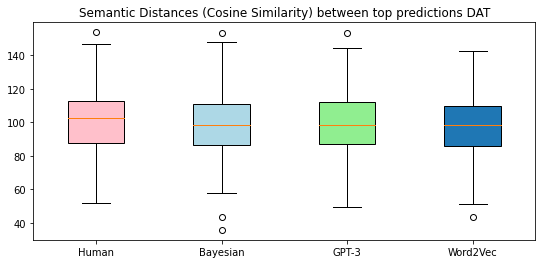

<Figure size 720x504 with 0 Axes>

In [449]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

fig = plt.figure(figsize =(10, 7))
 
data = [DAT_data[k] for k in DAT_data.keys()]
colors = ['pink', 'lightblue', 'lightgreen']
bplot = ax.boxplot(data,patch_artist=True,labels=DAT_data.keys())
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title("Semantic Distances (Cosine Similarity) between top predictions DAT")
# show plot
plt.show()

In [291]:
for i,q in enumerate(questions):
    print('====')
    print('question: ',q)
    q1, q2, q3 = q
    best=[-1,None]
    for w in word2idx.keys():
        querries = [[w+'_'+q[i],q[i]+'_'+w,w+'-'+q[i],q[i]+'-'+w,w+q[i],q[i]+w] for i in range(3)]

        
        scores = []
        for j,querry_subset in enumerate(querries):
            subscore = max([(getmatchstrength(qu,q[j],w),qu) for qu in querry_subset],key=lambda x:x[0])
            scores.append(subscore)
            
        totscore = 1
        for s in scores:
            totscore*=s[0]+1e4
        if best[0]<totscore:
            #print([s[1] for s in scores if s[0]>0])
            best=[totscore,w]

    print('answer/prediction: ',answers[i],"/", best[1])


====
question:  ['cottage', 'swiss', 'cake']


NameError: name 'P_Q_W' is not defined

In [254]:
for e in wn.synsets('schoolhouse',wn.NOUN):
    print(e.definition())
    print(e.lemma_names())
    




a building where young people receive education
['school', 'schoolhouse']


In [ ]:
['flake', 'mobile', 'cone']
answer:  snow
prediction:  book

In [59]:
"""
from num2words import num2words

numwords = set()
for i in range(2,100000000,10001):
    for w in num2words(i).split('and'):
        numwords.add(w.strip().replace( ' ', '_'))
len(numwords)
"""

2179

127

'one billion'

In [48]:
len(wordlist2)

76610

In [52]:
wordlist2

{'a_la_carte': 0,
 'abandoned': 5,
 'aboriginal': 6,
 'absolute': 1,
 'abstract': 9,
 'abstracted': 9,
 'abused': 4,
 'academic': 2,
 'accented': 98,
 'accessory': 7,
 'according': 18,
 'ace': 93,
 'aching': 2,
 'acid': 4,
 'acting': 6,
 'active': 16,
 'adamant': 1,
 'additive': 5,
 'addressed': 46,
 'adept': 12,
 'adherent': 4,
 'adhesive': 3,
 'adjective': 5,
 'adjunct': 5,
 'adolescent': 13,
 'adult': 14,
 'advance': 37,
 'advanced': 37,
 'advancing': 37,
 'aegean': 7,
 'aerial': 15,
 'aesthetic': 1,
 'affected': 1,
 'affecting': 1,
 'afghan': 1,
 'aged': 1,
 'agglomerate': 16,
 'agglomerated': 16,
 'aggregate': 15,
 'aggregated': 15,
 'aided': 98,
 'aired': 120,
 'alabaster': 2,
 'alarmed': 12,
 'alarming': 12,
 'alien': 24,
 'aliquot': 1,
 'allied': 5,
 'alligatored': 2,
 'almighty': 14,
 'alpha': 1,
 'alternate': 2,
 'alternating': 2,
 'alternative': 19,
 'amateur': 11,
 'amber': 9,
 'american': 35,
 'ammoniac': 1,
 'analog': 6,
 'analogue': 6,
 'anatomical': 2,
 'angered': 23,
 

True

In [51]:
76610*76610*4/(2**30)

21.864071860909462

In [31]:
len()

22563

In [103]:
'ice_skate' in wordlist

True

In [ ]:
tags = nltk.pos_tag(wordlist)
nouns = []
for w in wordlist:
    try:
        if wn.synsets(wn.morphy(w),wn.NOUN):
            nouns.append(w)
    except:
        pass

print(len(nouns))
nouns= set(nouns)

NameError: name 'reduced' is not defined